# Tarefa 1 - Classificador e Regressor
## Importar Bibliotecas

In [739]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_validate

O data set é gerado direto pelo arquivo gerar_dados_vitimas.py disponibilizado pelo professor (único parâmetro alterado foi o número de vítimas)

In [740]:
df_treino = pd.read_csv('datasets/vict/10v/data.csv')
print(f"Dataset com {len(df_treino)} vítimas")
print(df_treino.head())
X = df_treino.iloc[:, 0:10].values   # colunas 1 a 10
y = df_treino["tri"].values          # coluna 13

Dataset com 800 vítimas
   idade   fc  fr  pas  spo2       temp  pr  sg  fx  queim  gcs  avpu  tri  \
0     21    0   0    0    17  26.291506   0   3   0      0    3     3    3   
1     21  109  25   96    93  37.353475   1   1   0      0   13     1    1   
2     30  102  26   96    92  37.708092   0   1   1      0   13     0    1   
3     18    2   0    0    37  27.775682   0   3   0      3    3     3    3   
4     23   95  18  114    98  36.894670   1   0   1      0   15     0    0   

   sobr  
0  0.22  
1  0.92  
2  0.86  
3  0.24  
4  0.98  


## Divisão de Dataset de Treino (75%) e Teste(25%)

In [741]:
## Dividir o dataset em treinamento/validação e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, shuffle=True)
print(f"Tamanho total do dataset: {len(X)}\n")
print(f"Dados de treinamento X ({len(X_treino)}):\n{X_treino[:3]} ...")
print(f"Dados de treinamento y:({len(y_treino)})\n {y_treino[:3]} ...")
print("---")
print(f"Dados de teste   X ({len(X_teste)}):\n{X_teste[:3]} ...")
print(f"Dados de teste   y:({len(y_teste)})\n {y_teste[:3]} ...")

Tamanho total do dataset: 800

Dados de treinamento X (600):
[[ 26.          74.          13.         125.          97.
   36.98166736   1.           0.           1.           0.        ]
 [ 23.         118.          23.         103.          94.
   38.10701677   0.           2.           0.           0.        ]
 [ 23.         158.          32.          64.          80.
   34.24706777   0.           3.           1.           3.        ]] ...
Dados de treinamento y:(600)
 [0 0 2] ...
---
Dados de teste   X (200):
[[ 28.          72.          18.         129.         100.
   36.52421294   1.           0.           1.           0.        ]
 [ 22.           0.           0.           3.          61.
   26.96221093   0.           3.           0.           3.        ]
 [ 19.           0.           1.           0.          15.
   30.85076924   0.           3.           0.           0.        ]] ...
Dados de teste   y:(200)
 [0 3 3] ...


# Definição dos parâmetros

In [742]:
print("Distribuição das classes no conjunto de dados:")
print(pd.Series(y).value_counts())

depth1 = 2
leaf1 = 0.25
depth2 = 4
leaf2 = 0.8
depth3 = 16
leaf3 = 0.01
scores_treino = []
scores_validos = []

Distribuição das classes no conjunto de dados:
2    207
0    202
3    198
1    193
Name: count, dtype: int64


## Primeira Parametrização

In [743]:
# parâmetros para o grid search
parameters1 = [
    {'criterion': ['entropy'], 'max_depth': [depth1], 'min_samples_leaf': [leaf1]}
]


# instantiate model
model1 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf1 = GridSearchCV(model1, parameters1, cv=3, scoring='f1_macro', verbose=4, return_train_score=True)
clf1.fit(X_treino, y_treino)
best1 = clf1.best_estimator_
scores_treino.append([
    clf1.cv_results_['split0_train_score'][0],
    clf1.cv_results_['split1_train_score'][0],
    clf1.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf1.cv_results_['split0_test_score'][0],
    clf1.cv_results_['split1_test_score'][0],
    clf1.cv_results_['split2_test_score'][0]
])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=0.25;, score=(train=0.657, test=0.651) total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=0.25;, score=(train=0.652, test=0.662) total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=0.25;, score=(train=0.656, test=0.653) total time=   0.0s


## Teste

In [744]:
y_pred_treino1 = clf1.predict(X_treino)
acc_treino1 = accuracy_score(y_treino, y_pred_treino1) * 100
print(f"Acuracia com dados de treino: {acc_treino1:.2f}%")
# com dados de teste
y_pred_teste1 = clf1.predict(X_teste)
acc_teste1 = accuracy_score(y_teste, y_pred_teste1) * 100
print(f"Acuracia com dados de teste: {acc_teste1:.2f}%")

Acuracia com dados de treino: 74.67%
Acuracia com dados de teste: 68.00%


## Segunda Parametrização

In [745]:
# parâmetros para o grid search
parameters2 = [
    {'criterion': ['entropy'], 'max_depth': [depth2], 'min_samples_leaf': [leaf2]}
]


# instantiate model
model2 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf2 = GridSearchCV(model2, parameters2, cv=3, scoring='f1_macro', verbose=4, return_train_score=True)
clf2.fit(X_treino, y_treino)
best2 = clf2.best_estimator_
scores_treino.append([
    clf2.cv_results_['split0_train_score'][0],
    clf2.cv_results_['split1_train_score'][0],
    clf2.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf2.cv_results_['split0_test_score'][0],
    clf2.cv_results_['split1_test_score'][0],
    clf2.cv_results_['split2_test_score'][0]
])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=4, min_samples_leaf=0.8;, score=(train=0.103, test=0.105) total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, min_samples_leaf=0.8;, score=(train=0.104, test=0.103) total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, min_samples_leaf=0.8;, score=(train=0.104, test=0.103) total time=   0.0s


## Teste

In [746]:
y_pred_treino2 = clf2.predict(X_treino)
acc_treino2 = accuracy_score(y_treino, y_pred_treino2) * 100
print(f"Acuracia com dados de treino: {acc_treino2:.2f}%")
# com dados de teste
y_pred_teste2 = clf2.predict(X_teste)
acc_teste2 = accuracy_score(y_teste, y_pred_teste2) * 100
print(f"Acuracia com dados de teste: {acc_teste2:.2f}%")

Acuracia com dados de treino: 26.17%
Acuracia com dados de teste: 22.50%


## Terceira Parametrização

In [747]:
# parâmetros para o grid search
parameters3 = [
    {'criterion': ['entropy'], 'max_depth': [depth3], 'min_samples_leaf': [leaf3]}
]


# instantiate model
model3 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf3 = GridSearchCV(model3, parameters3, cv=3, scoring='f1_macro', verbose=4, return_train_score=True)
clf3.fit(X_treino, y_treino)
best3 = clf3.best_estimator_
scores_treino.append([
    clf3.cv_results_['split0_train_score'][0],
    clf3.cv_results_['split1_train_score'][0],
    clf3.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf3.cv_results_['split0_test_score'][0],
    clf3.cv_results_['split1_test_score'][0],
    clf3.cv_results_['split2_test_score'][0]
])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=16, min_samples_leaf=0.01;, score=(train=0.985, test=0.970) total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=16, min_samples_leaf=0.01;, score=(train=0.978, test=0.980) total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=16, min_samples_leaf=0.01;, score=(train=0.980, test=0.980) total time=   0.0s


## Teste

In [748]:
y_pred_treino3 = clf3.predict(X_treino)
acc_treino3 = accuracy_score(y_treino, y_pred_treino3) * 100
print(f"Acuracia com dados de treino: {acc_treino3:.2f}%")
# com dados de teste
y_pred_teste3 = clf3.predict(X_teste)
acc_teste3 = accuracy_score(y_teste, y_pred_teste3) * 100
print(f"Acuracia com dados de teste: {acc_teste3:.2f}%")

Acuracia com dados de treino: 98.00%
Acuracia com dados de teste: 99.50%


## Matriz de confusão da primeira parametrização

c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      0.98      0.99        43
           2       0.00      0.00      0.00        63
           3       0.43      1.00      0.60        49

    accuracy                           0.68       200
   macro avg       0.61      0.74      0.65       200
weighted avg       0.55      0.68      0.59       200



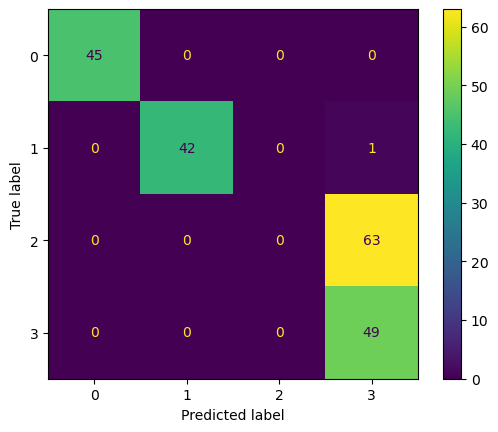

In [749]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste1)
print(classification_report(y_teste, y_pred_teste1))

## Matriz de confusão da segunda parametrização

              precision    recall  f1-score   support

           0       0.23      1.00      0.37        45
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        63
           3       0.00      0.00      0.00        49

    accuracy                           0.23       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.23      0.08       200



c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

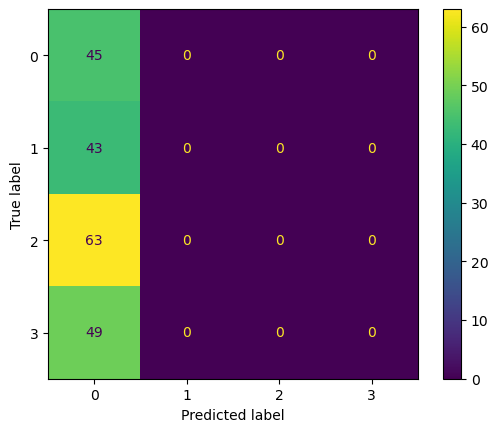

In [750]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste2)
print(classification_report(y_teste, y_pred_teste2))

## Matriz de confusão da terceira parametrização

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      0.98      0.99        43
           2       1.00      1.00      1.00        63
           3       0.98      1.00      0.99        49

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



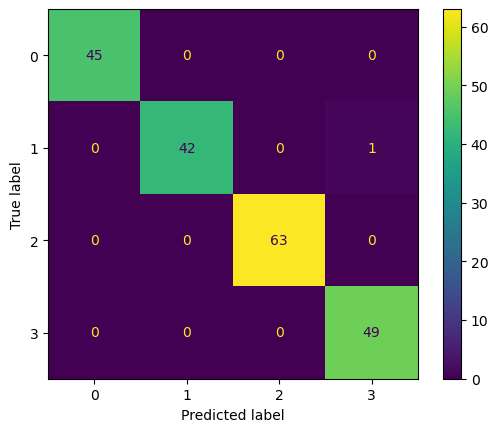

In [751]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste3)
print(classification_report(y_teste, y_pred_teste3))

## Viés e Variância

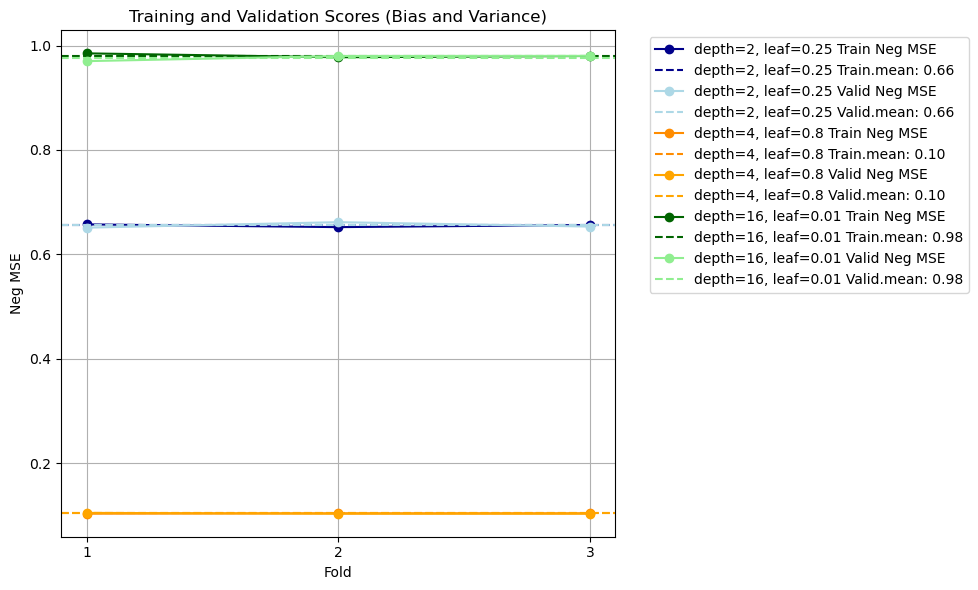

In [752]:
# Exemplo de definição (substitua pelos seus valores reais)
num_params = 3  # Número de conjuntos de parâmetros testados
k_folds = 3     # Número de folds usados na validação cruzada

# Exemplo de listas de scores (substitua pelos seus resultados reais)
# scores_treino = [[...], [...], [...]]
# scores_validos = [[...], [...], [...]]

plt.figure(figsize=(10, 6))
colors = [
    ["darkblue", "lightblue"],
    ["darkorange", "orange"],
    ["darkgreen", "lightgreen"],
]

for i in range(num_params):
    plt.plot(range(1, len(scores_treino[i]) + 1), scores_treino[i], label=f"{labels[i]} Train Neg MSE", marker='o', color=colors[i][0])
    plt.axhline(np.mean(scores_treino[i]), color=colors[i][0], linestyle='--', label=f"{labels[i]} Train.mean: {np.mean(scores_treino[i]):.2f}")
    plt.plot(range(1, len(scores_validos[i]) + 1), scores_validos[i], label=f"{labels[i]} Valid Neg MSE", marker='o', color=colors[i][1])
    plt.axhline(np.mean(scores_validos[i]), color=colors[i][1], linestyle='--', label=f"{labels[i]} Valid.mean: {np.mean(scores_validos[i]):.2f}")

plt.xlabel("Fold")
plt.ylabel("Neg MSE")
plt.title("Training and Validation Scores (Bias and Variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(np.arange(1, k_folds + 1, 1))
plt.grid()
plt.tight_layout()
plt.show()


## Árvores de decisão

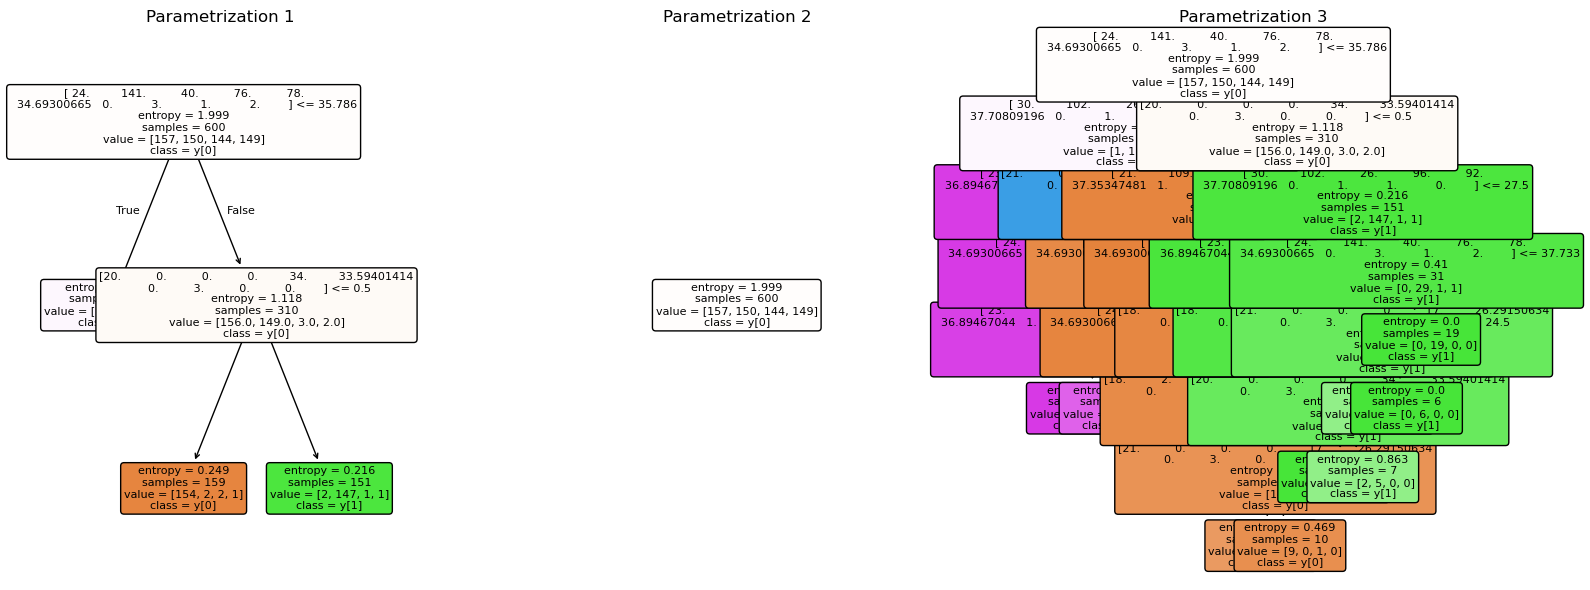

In [753]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

tree.plot_tree(best1,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[0])  # Assign the plot to the correct subplot
axes.flatten()[0].set_title(f"Parametrization {1}")  # Add a title to each subplot
tree.plot_tree(best2,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[1])  # Assign the plot to the correct subplot
axes.flatten()[1].set_title(f"Parametrization {2}")  # Add a title to each subplot
tree.plot_tree(best3,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[2])  # Assign the plot to the correct subplot
axes.flatten()[2].set_title(f"Parametrization {3}")  # Add a title to each subplot

plt.tight_layout()  # Adjust spacing between subplots
plt.show()